# Tomato Disease Classification

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/tometo.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c4262ec-08e3-4bba-8dd4-9855476f92a1___YLCV_GCREC 2120.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c60c0aa-ae90-4a67-93d9-715ef660e53a___UF.GRC_YLCV_Lab 03026.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c69b9bb-96c9-492f-a7e4-8197c580d43d___UF.GRC_YLCV_Lab 01686.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c75505b-16a6-4a66-81d8-61636db17edd___YLCV_NREC 2023.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c773e62-28a8-4f16-a71f-7cdb1c5751e5___UF.GRC_YLCV_Lab 01855.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c7a109a-f8ff-4fda-8a24-a57a593e19ef___UF.GRC_YLCV_Lab 02946.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c80744a-44c1-4f29-85d8-84fa1aa99745___UF.GRC_YLCV_Lab 02749.JPG  
  inflating: tometo/Tomato__Tomato_YellowLeaf__Curl_Virus/4c8a1262-55e1-452c-86c5-5cb1f

### Import data into tensorflow dataset object

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/tometo",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5984 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 3 0 3 2 3 3 3 1 3 2 1 1 1 1 1 3 0 3 2 2 2 3 2 0 2 2 2]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

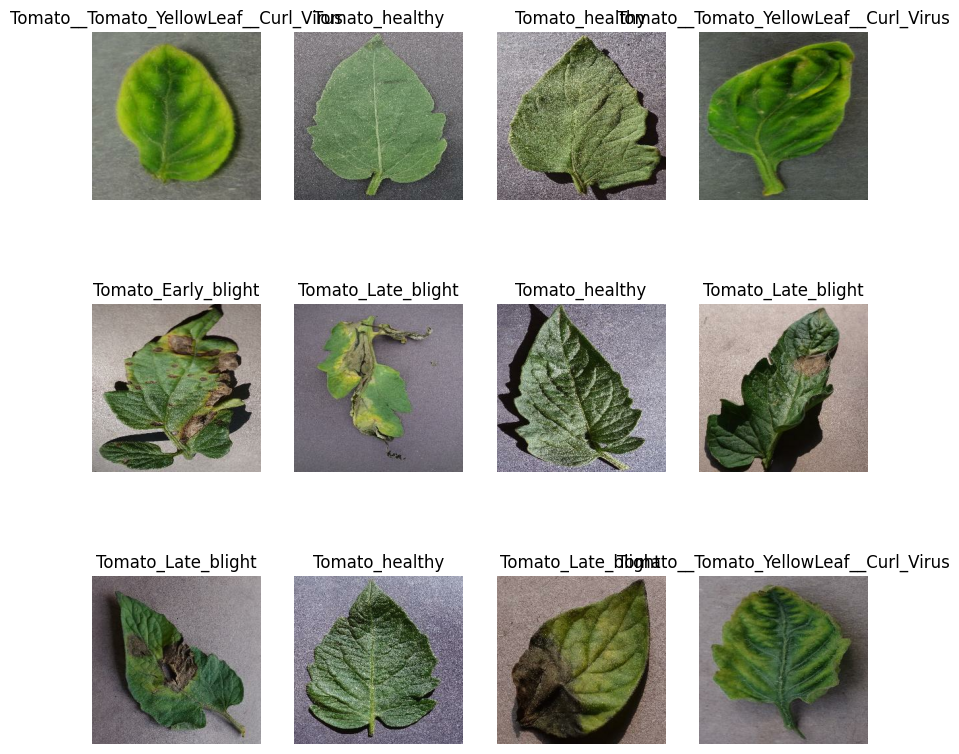

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:
len(dataset)

187

In [ ]:
train_size = 0.8
len(dataset)*train_size

149.6

In [ ]:
train_ds = dataset.take(149)
len(train_ds)

149

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [ ]:
val_size=0.1
len(dataset)*val_size

2.7

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

149

In [ ]:
len(val_ds)

18

In [ ]:
len(test_ds)

20

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
149/149 [==============================] - 63s 339ms/step - loss: 0.9585 - accuracy: 0.5596 - val_loss: 0.6147 - val_accuracy: 0.7396
Epoch 2/50
149/149 [==============================] - 42s 281ms/step - loss: 0.5700 - accuracy: 0.7720 - val_loss: 0.3846 - val_accuracy: 0.8316
Epoch 3/50
149/149 [==============================] - 42s 283ms/step - loss: 0.4151 - accuracy: 0.8381 - val_loss: 0.3540 - val_accuracy: 0.8524
Epoch 4/50
149/149 [==============================] - 42s 282ms/step - loss: 0.3630 - accuracy: 0.8559 - val_loss: 0.4390 - val_accuracy: 0.8351
Epoch 5/50
149/149 [==============================] - 42s 279ms/step - loss: 0.3022 - accuracy: 0.8790 - val_loss: 0.3238 - val_accuracy: 0.8524
Epoch 6/50
149/149 [==============================] - 42s 279ms/step - loss: 0.3086 - accuracy: 0.8777 - val_loss: 0.3146 - val_accuracy: 0.8715
Epoch 7/50
149/149 [==============================] - 42s 284ms/step - loss: 0.2768 - accuracy: 0.8878 - val_loss: 0.2622 - val_ac

In [ ]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 22s 3s/step - loss: 0.6701 - accuracy: 0.7311


In [ ]:
scores

[0.6700705885887146, 0.7310924530029297]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 149}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9585206508636475,
 0.569974958896637,
 0.41505420207977295,
 0.3629585802555084,
 0.30216529965400696]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

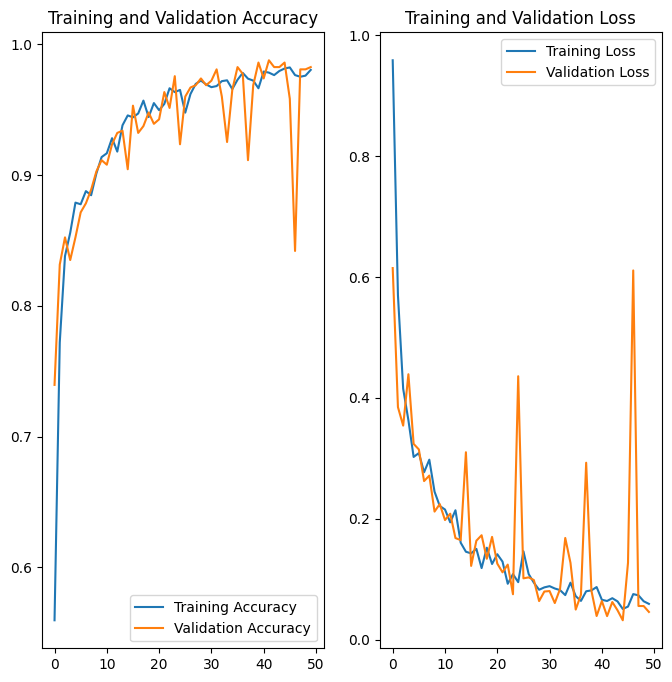

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model


In [ ]:
model_json = model.to_json()
with open("cotton1.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("cotton1.h5")
print("Saved model to disk")

Saved model to disk
